In [156]:
%matplotlib inline
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

(175, 400)

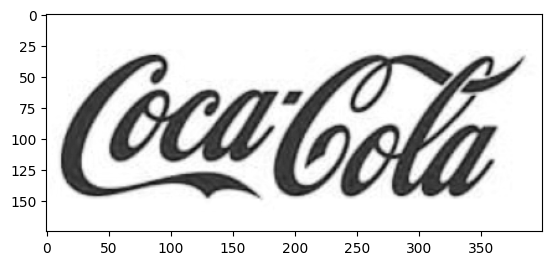

In [157]:
# Cargamos la imagen a procesar
template = cv.imread(r'template\pattern.png',0)

plt.figure()
plt.imshow(template, cmap="gray")
template.shape

In [158]:
w_original, h_original = template.shape[::-1]
print (template.shape)
edges = cv.Canny(template, threshold1=5, threshold2=130)
edges = cv.bitwise_not(edges)
print(edges.shape)

(175, 400)
(175, 400)


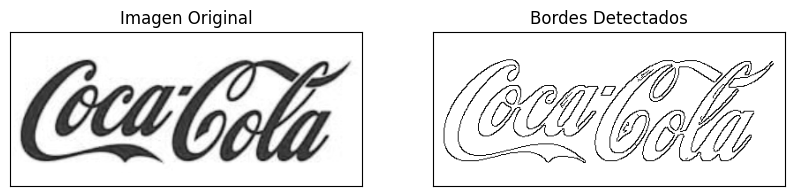

In [159]:
# Visualizamos la imagen original y los bordes detectados
plt.figure(figsize=(10, 5))

# Mostramos la imagen original en el subplot de la izquierda
plt.subplot(1, 2, 1)
plt.imshow(template, cmap='gray')
plt.title('Imagen Original')
plt.xticks([]), plt.yticks([])

# Mostramos los bordes detectados en el subplot de la derecha
plt.subplot(1, 2, 2)
plt.imshow(edges, cmap='gray')
plt.title('Bordes Detectados')
plt.xticks([]), plt.yticks([])

plt.show()

In [160]:
def detect_img(img_template,img_detect,method):
    
    
    w_template, h_template = img_template.shape[::-1]
    img_salida = img_detect.copy()
    img_gray= cv.cvtColor(img_salida,cv.COLOR_BGR2GRAY)
    edges = cv.Canny(img_gray, threshold1=5, threshold2=130)
    w_img, h_img = edges.shape[::-1]
    
    template_copy = img_template.copy()
    if (w_template>w_img) | (h_template>h_img):
        template_copy = cv.resize(template_copy, (img_gray.shape[1], int(img_gray.shape[1]*template_copy.shape[0]/template_copy.shape[1])))
        h_template, h_template = template_copy.shape[::-1]
        
    scales = np.linspace(0.1, 1, 100)
    maximo = 0
    final_scale = scales[0]
    meth = eval(method)
    for scale in scales:
        template_resized = cv.resize(template_copy, None, fx=scale, fy=scale)
        template_resized = cv.Canny(template_resized, threshold1=5, threshold2=130)
        w, h = template_resized.shape[::-1]
        try:
            res = cv.matchTemplate(edges, template_resized, meth)
            min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)
            print(f"Escala {scale} probada, max value= {max_val}")
            # imprime_rtdos(img_salida,img_template,final_scale,method,min_loc,max_loc)
            if max_val >= maximo:
                maximo = max_val
                final_scale = scale
                print(f"final scale: {final_scale}")
        except cv.error as e:
            print(f"Error al realizar la coincidencia de plantillas a escala {scale}: {e}")
            break
        
    template_resized = cv.resize(img_template, None, fx=final_scale, fy=final_scale)
    w, h = template_resized.shape[::-1]
    
    try:
        res = cv.matchTemplate(edges, template_resized, meth)
        print(f"Escala final aplicada:{final_scale}")
        min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)

    except cv.error as e:
        print(f"Error al realizar la coincidencia de plantillas a escala final {final_scale}: {e}")
    
    # Si el método es TM_SQDIFF o TM_SQDIFF_NORMED, tomamos el mínimo
    if method in [cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED]:
        top_left = min_loc
    else:
        top_left = max_loc
    print(f"Mejor escala: {final_scale}")
    
    # Marcamos el lugar donde lo haya encontrado
    #----------------------------------------
    bottom_right = (top_left[0] + w, top_left[1] + h)
    cv.rectangle(img_salida, top_left, bottom_right, 0, 5)
    
    # Mostramos la imagen original con el rectángulo delimitador
    img_salida_rgb = cv.cvtColor(img_salida, cv.COLOR_BGR2RGB)
    plt.imshow(img_salida_rgb)
    plt.title('Detected Point')
    plt.xticks([]), plt.yticks([])
    plt.suptitle(method)
    plt.show()

Escala 0.1 probada, max value= 2470950.0
final scale: 0.1
Escala 0.1090909090909091 probada, max value= 2535975.0
final scale: 0.1090909090909091
Escala 0.1181818181818182 probada, max value= 3381299.75
final scale: 0.1181818181818182
Escala 0.1272727272727273 probada, max value= 3381300.0
final scale: 0.1272727272727273
Escala 0.13636363636363635 probada, max value= 3381299.5
Escala 0.14545454545454545 probada, max value= 3576375.0
final scale: 0.14545454545454545
Escala 0.15454545454545454 probada, max value= 3901499.5
final scale: 0.15454545454545454
Escala 0.16363636363636364 probada, max value= 3706425.0
Escala 0.17272727272727273 probada, max value= 4551750.0
final scale: 0.17272727272727273
Escala 0.18181818181818182 probada, max value= 4811850.0
final scale: 0.18181818181818182
Escala 0.19090909090909092 probada, max value= 5071950.0
final scale: 0.19090909090909092
Escala 0.2 probada, max value= 4941900.0
Escala 0.2090909090909091 probada, max value= 5722200.5
final scale: 0.2

Escala 0.4818181818181818 probada, max value= 18532128.0
final scale: 0.4818181818181818
Escala 0.49090909090909085 probada, max value= 18272026.0
Escala 0.5 probada, max value= 19507500.0
final scale: 0.5
Escala 0.509090909090909 probada, max value= 19767598.0
final scale: 0.509090909090909
Escala 0.5181818181818182 probada, max value= 19052324.0
Escala 0.5272727272727272 probada, max value= 20547900.0
final scale: 0.5272727272727272
Escala 0.5363636363636364 probada, max value= 20938048.0
final scale: 0.5363636363636364
Escala 0.5454545454545454 probada, max value= 21718348.0
final scale: 0.5454545454545454
Escala 0.5545454545454546 probada, max value= 21133124.0
Escala 0.5636363636363636 probada, max value= 23148898.0
final scale: 0.5636363636363636
Escala 0.5727272727272728 probada, max value= 23604076.0
final scale: 0.5727272727272728
Escala 0.5818181818181818 probada, max value= 23604078.0
final scale: 0.5818181818181818
Escala 0.5909090909090909 probada, max value= 23669100.0
fi

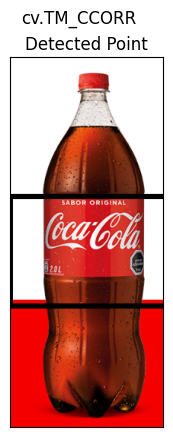

In [161]:
# Los 6 métodos posibles para comparación:
# methods = ['cv.TM_CCOEFF', 'cv.TM_CCOEFF_NORMED', 'cv.TM_CCORR',
#             'cv.TM_CCORR_NORMED', 'cv.TM_SQDIFF', 'cv.TM_SQDIFF_NORMED']

try:
    img_detect=cv.imread(r'images\coca_logo_1.png')
except Exception as e:
    print(f"Error al leer la imagen: {e}")
detect_img(template,img_detect,'cv.TM_CCORR')

Escala 0.1 probada, max value= 3381299.5
final scale: 0.1
Escala 0.1090909090909091 probada, max value= 4031549.75
final scale: 0.1090909090909091
Escala 0.1181818181818182 probada, max value= 4031549.75
final scale: 0.1181818181818182
Escala 0.1272727272727273 probada, max value= 5006925.0
final scale: 0.1272727272727273
Escala 0.13636363636363635 probada, max value= 4941900.0
Escala 0.14545454545454545 probada, max value= 5071950.0
final scale: 0.14545454545454545
Escala 0.15454545454545454 probada, max value= 6307425.0
final scale: 0.15454545454545454
Escala 0.16363636363636364 probada, max value= 6632550.0
final scale: 0.16363636363636364
Escala 0.17272727272727273 probada, max value= 7282799.5
final scale: 0.17272727272727273
Escala 0.18181818181818182 probada, max value= 7672950.0
final scale: 0.18181818181818182
Escala 0.19090909090909092 probada, max value= 8193149.5
final scale: 0.19090909090909092
Escala 0.2 probada, max value= 8843400.0
final scale: 0.2
Escala 0.209090909090

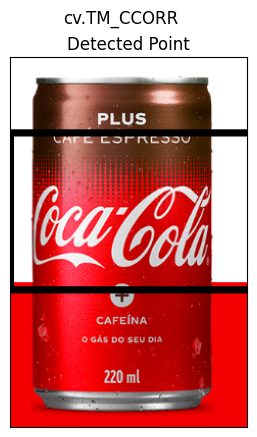

In [162]:
try:
    img_detect=cv.imread(r'images\coca_logo_2.png')
except Exception as e:
    print(f"Error al leer la imagen: {e}")
detect_img(template,img_detect,'cv.TM_CCORR')

Escala 0.1 probada, max value= 5982299.5
final scale: 0.1
Escala 0.1090909090909091 probada, max value= 6697575.0
final scale: 0.1090909090909091
Escala 0.1181818181818182 probada, max value= 7477874.5
final scale: 0.1181818181818182
Escala 0.1272727272727273 probada, max value= 9103499.0
final scale: 0.1272727272727273
Escala 0.13636363636363635 probada, max value= 9103501.0
final scale: 0.13636363636363635
Escala 0.14545454545454545 probada, max value= 10078874.0
final scale: 0.14545454545454545
Escala 0.15454545454545454 probada, max value= 11119275.0
final scale: 0.15454545454545454
Escala 0.16363636363636364 probada, max value= 12289724.0
final scale: 0.16363636363636364
Escala 0.17272727272727273 probada, max value= 13330125.0
final scale: 0.17272727272727273
Escala 0.18181818181818182 probada, max value= 13330124.0
Escala 0.19090909090909092 probada, max value= 14890726.0
final scale: 0.19090909090909092
Escala 0.2 probada, max value= 16126200.0
final scale: 0.2
Escala 0.2090909

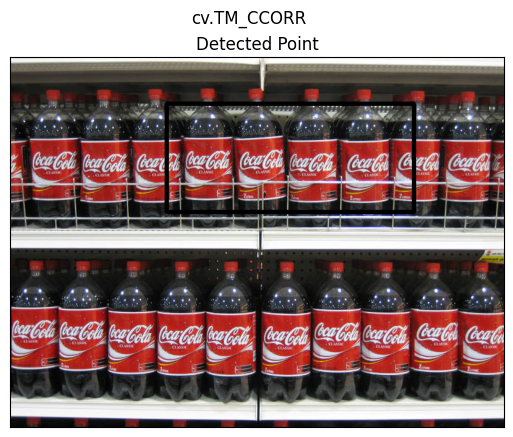

In [163]:
try:
    img_detect=cv.imread(r'images\coca_multi.png')
except Exception as e:
    print(f"Error al leer la imagen: {e}")
detect_img(template,img_detect,'cv.TM_CCORR')

Escala 0.1 probada, max value= 6112349.5
final scale: 0.1
Escala 0.1090909090909091 probada, max value= 6437474.5
final scale: 0.1090909090909091
Escala 0.1181818181818182 probada, max value= 6762600.5
final scale: 0.1181818181818182
Escala 0.1272727272727273 probada, max value= 8128124.5
final scale: 0.1272727272727273
Escala 0.13636363636363635 probada, max value= 8063099.0
Escala 0.14545454545454545 probada, max value= 9298574.0
final scale: 0.14545454545454545
Escala 0.15454545454545454 probada, max value= 10208924.0
final scale: 0.15454545454545454
Escala 0.16363636363636364 probada, max value= 10859174.0
final scale: 0.16363636363636364
Escala 0.17272727272727273 probada, max value= 11639475.0
final scale: 0.17272727272727273
Escala 0.18181818181818182 probada, max value= 12289725.0
final scale: 0.18181818181818182
Escala 0.19090909090909092 probada, max value= 13265100.0
final scale: 0.19090909090909092
Escala 0.2 probada, max value= 14045398.0
final scale: 0.2
Escala 0.20909090

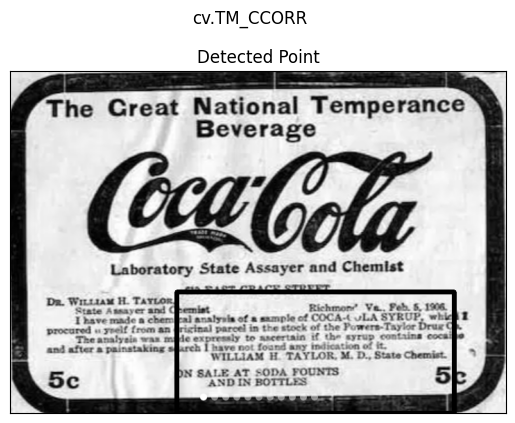

In [164]:
try:
    img_detect=cv.imread(r'images\coca_retro_1.png')
except Exception as e:
    print(f"Error al leer la imagen: {e}")
detect_img(template,img_detect,'cv.TM_CCORR')

Escala 0.1 probada, max value= 5982299.5
final scale: 0.1
Escala 0.1090909090909091 probada, max value= 6697575.0
final scale: 0.1090909090909091
Escala 0.1181818181818182 probada, max value= 7477874.5
final scale: 0.1181818181818182
Escala 0.1272727272727273 probada, max value= 9103499.0
final scale: 0.1272727272727273
Escala 0.13636363636363635 probada, max value= 9103501.0
final scale: 0.13636363636363635
Escala 0.14545454545454545 probada, max value= 10078874.0
final scale: 0.14545454545454545
Escala 0.15454545454545454 probada, max value= 11119275.0
final scale: 0.15454545454545454
Escala 0.16363636363636364 probada, max value= 12289724.0
final scale: 0.16363636363636364
Escala 0.17272727272727273 probada, max value= 13330125.0
final scale: 0.17272727272727273
Escala 0.18181818181818182 probada, max value= 13330124.0
Escala 0.19090909090909092 probada, max value= 14890726.0
final scale: 0.19090909090909092
Escala 0.2 probada, max value= 16126200.0
final scale: 0.2
Escala 0.2090909

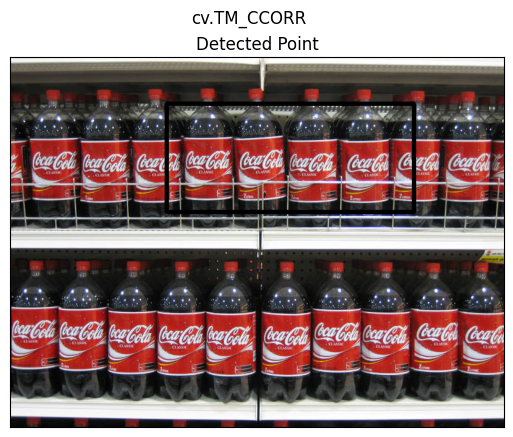

In [165]:
try:
    img_detect=cv.imread(r'images\coca_multi.png')
except Exception as e:
    print(f"Error al leer la imagen: {e}")
detect_img(template,img_detect,'cv.TM_CCORR')